# 3. Classification

## 3-1. Binary Classification

In [93]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier # SGD Classifier: train instances one by one(online learning)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone, BaseEstimator

SAMPLE_IDX = 36000
TOTAL_SIZE = 0
TRAIN_SIZE = 60000

In [4]:
def show_img(sample):
    # show sample digit image w/ pyplot
    sample_resize = sample.reshape(28, 28)

    plt.imshow(sample_resize, cmap = matplotlib.cm.binary, interpolation= "nearest")
    # cmap: color map / interpolation: whether to interpolate btw pixels if the display resolution is not the same as the image resolution
    plt.axis("off")
    plt.show()

(70000, 784) (70000,)


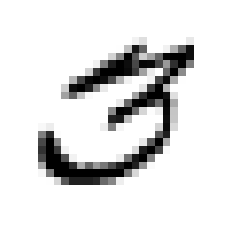

In [97]:
# fetch mnist data
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target']
TOTAL_SIZE = X.shape[0]
print(X.shape, y.shape) # X: (70000, 784) y: (70000,)

# shuffle and generate train, test set
shuffle_idx = np.random.permutation(TOTAL_SIZE)
X, y = X[shuffle_idx], y[shuffle_idx]
X_train, y_train, X_test, y_test = X[:TRAIN_SIZE], y[:TRAIN_SIZE], X[TRAIN_SIZE:], y[TRAIN_SIZE:]

# show sample digit image w/ pyplot
X_sample = X[SAMPLE_IDX]
y_sample = y[SAMPLE_IDX]
show_img(X_sample)

In [7]:
# binary classifier - 5 for not
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

print("answer:", y_sample)
print("prediction:", sgd_clf.predict([X_sample]))

answer: 3
prediction: [False]


In [9]:
# measurement of binary classifier
skfolds = StratifiedKFold(n_splits=3)

# measurement 1 : stratifiedKFold
for train_idx, check_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_fold = y_train_5[train_idx]
    X_check_folds = X_train[check_idx]
    y_check_fold = y_train_5[check_idx]

    clone_clf.fit(X_train_folds, y_train_fold)
    y_pred = clone_clf.predict(X_check_folds)
    n_correct = sum(y_pred == y_check_fold)
    print(n_correct/ len(y_pred)) # 0.9683 0.9635 0.9717

0.957
0.96435
0.9664


In [10]:
# measurement 2 : cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")) # [0.9683 0.9635 0.9717]

[0.957   0.96435 0.9664 ]


In [11]:
# measurement 3 : compare with dumb classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): pass
    def predict(self, X): return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv =3, scoring="accuracy")) #[0.90765 0.9122  0.90985]

[0.9094  0.91195 0.90925]


## 3-2. Multiclass Classification

- OvA; One-versus-All

In [56]:
# scikit-learn automatically runs OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[SAMPLE_IDX]])

sample_scores = sgd_clf.decision_function([X[SAMPLE_IDX]])
sample_scores

array([[-21503.52407724, -26347.29138494, -13411.29085455,
          4147.63815463, -15363.03852528,  -2673.00909136,
        -19491.03734327, -17514.51225994,  -3779.56661959,
         -9651.60152854]])

In [59]:
idx, predicting = np.argmax(sample_scores), sgd_clf.classes_[idx]
idx, predicting

(3, '3')

- OvO; One-versus-one

In [64]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X[SAMPLE_IDX]])

# print(len(ovo_clf.estimators_), '\n',ovo_clf.estimators_)

array(['3'], dtype=object)

In [65]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[SAMPLE_IDX]])

array(['3'], dtype=object)

In [66]:
forest_clf.predict_proba([X[SAMPLE_IDX]])

array([[0.  , 0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [67]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87715, 0.87985, 0.87175])

## 3-3. Multilabel Classification

In [98]:
from sklearn.neighbors import KNeighborsClassifier

y_train = np.array(list(map(int, y_train)))
y_train_large = (y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd] #np.c_ : column 방향으로 데이터 추가

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([X[SAMPLE_IDX]])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_macro = f1_score(y_train, y_train_knn_pred, average="macro")
f1_weighted = f1_score(y_train, y_train_knn_pred, average="weighted") # give more weight to the classifier's score depending on its support(i.e. the number of instances with that target label)

In [ ]:
f1_macro

In [ ]:
f1_weighted

## 3-4. Multioutput Classification

: generalization of multilabel classification, each label can be multiclass

In [ ]:
# get rid of noise
noise =np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise =np.random.randint(0, 100, (len(test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn.clf.predict([X_test_mod[SAMPLE_IDX]])


show_img(clean_digit[0])

## 3-5. Measuring Accuracy - using cross validation

### 1) Confuion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53484,  1128],
       [ 1117,  4271]], dtype=int64)

In [20]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

precision, recall

(0.7910724208186701, 0.7926874536005939)

In [28]:
# decision_function: returns score
y_scores = sgd_clf.decision_function([X_train[SAMPLE_IDX]])
threshold = 0
y_sample_digit_pred = (y_scores > threshold)
y_sample_digit_pred

array([False])

In [33]:
#return decision scores instead of predictions
# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) : returns scores

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

### 2) Precision-Recall Curve

()


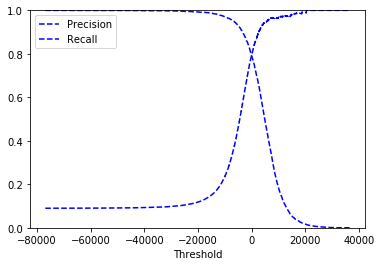

In [34]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

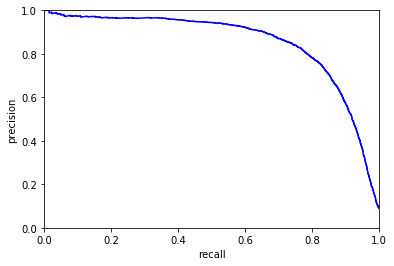

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

plot_precision_vs_recall(precisions, recalls)

### 3) ROC curve; Receiver Operating Chracteristic curve

x: false positive rate, y: true positive rate(=recall)

AUC;Area Under the Curve를 사용하여 classifier 비교

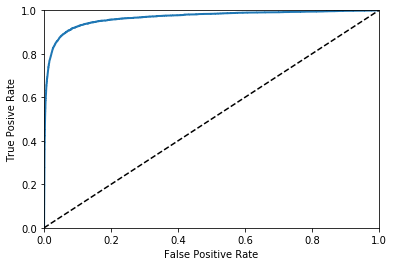

In [48]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9665456034012175

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

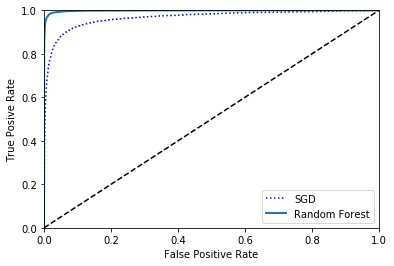

In [53]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984201415142123

## 3-5. Error Analysis

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90585, 0.89855, 0.9039 ])

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5628,    0,   15,    7,   11,   42,   36,    5,  208,    1],
       [   0, 6397,   42,   17,    4,   41,    8,    6,  184,   15],
       [  25,   22, 5282,   75,   69,   26,   68,   38,  335,   14],
       [  25,   17,  111, 5253,    4,  206,   18,   43,  351,   74],
       [   9,   17,   52,   10, 5217,    9,   40,   22,  294,  178],
       [  30,   20,   31,  166,   52, 4451,   85,   17,  471,   65],
       [  28,   18,   41,    2,   44,   92, 5546,    5,  123,    0],
       [  21,   14,   64,   20,   45,    8,    5, 5744,  154,  215],
       [  18,   53,   46,   85,    4,  122,   36,    6, 5440,   57],
       [  29,   26,   27,   64,  136,   29,    2,  171,  293, 5208]],
      dtype=int64)

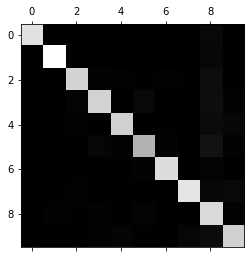

In [77]:
plt.matshow(conf_mx, cmap=plt.cm.gray) #Display an array as a matrix in a new figure window.
plt.show()

In [80]:
row_sums

array([[5953],
       [6714],
       [5954],
       [6102],
       [5848],
       [5388],
       [5899],
       [6290],
       [5867],
       [5985]], dtype=int64)

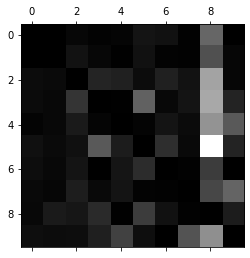

In [79]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # row: actual class, column: predicted class
plt.show() # element with white represents confusing pairs